Author: Lijing Wang, lijing52@stanford.edu (2021)

# Load data

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib
import rioxarray
import matplotlib as mpl
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,PrecisionRecallDisplay
warnings.filterwarnings("ignore")
#mpl.rcParams['figure.dpi'] = 144
plt.rcParams.update({'font.size': 13})

## bounding box
bbox = (546400,554100,6817000,6821500)

Domain size: ~ 7.7 km x 4.5 km 

Grid resolution: 6m 

## Input, remote sensing bands

In [2]:
# X_dir_list: dir list include all .tif (input data)
X_dir_list = [filename for filename in os.listdir('.') if filename.endswith(".tif")]
X_dir_list.sort()

In [3]:
# Load all X gridded data: 
name_list = [X_dir.split('.')[0] for X_dir in X_dir_list]
name_show_list = ['band0: “red” 630-690nm','band1: “near-red edge” 705nm-745nm',
                  'band2: “coastal” 400-450nm','band3: “blue” 450-510nm',
                  'band4: “green” 510-580nm','band5: “yellow” 585-625nm',
                  'band6: near-IR1 770-895nm','band7: near-IR2 860-1040nm']
[name_show_list.append(name) for name in ['ferric_silicate','ferrous_silicate','fe2','fe3']]

[None, None, None, None]

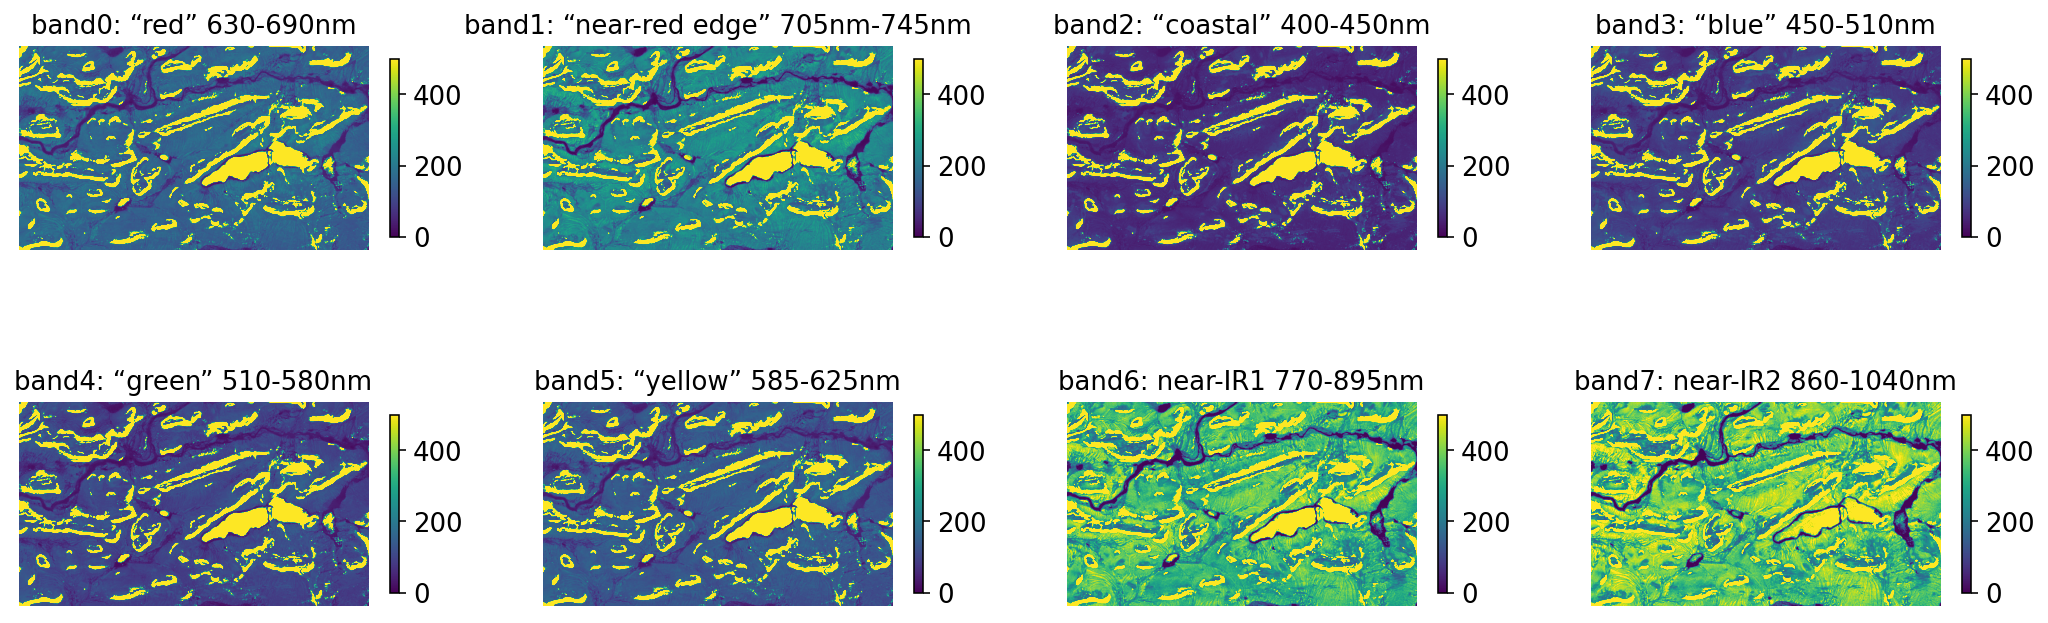

In [4]:
# Load all WV_band data: 
WV_band = {}
plt.figure(figsize=(18,6))
for i,name in enumerate(name_list): 
    ax = plt.subplot(2, 4, i+1)
    load = rioxarray.open_rasterio(X_dir_list[i],data_name=name)
    load = load.sel(band=1)
    
    WV_band[name] = load.data
    plt.imshow(WV_band[name],extent=bbox,vmin = 0,vmax = 500)
    plt.axis('off')
    plt.colorbar(shrink= 0.6)
    plt.title(name_show_list[i], fontdict = {'fontsize' : 13})

## Output: Rock type

In [5]:
# Load target classes
Day1 = gpd.read_file("Day1.gpkg")
Day20 = gpd.read_file("Day20_2classes.gpkg")

In [6]:
# RGB vis
def display_rgb(img, b_r, b_g, b_b, alpha=1.):
    rgb = np.stack([img[b_r], img[b_g], img[b_b]], axis=-1)
    rgb = rgb/300 * alpha
    return rgb
rgb = display_rgb(WV_band, 'band00', 'band05', 'band02', alpha=1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(546400.0, 554100.0, 6817000.0, 6821500.0)

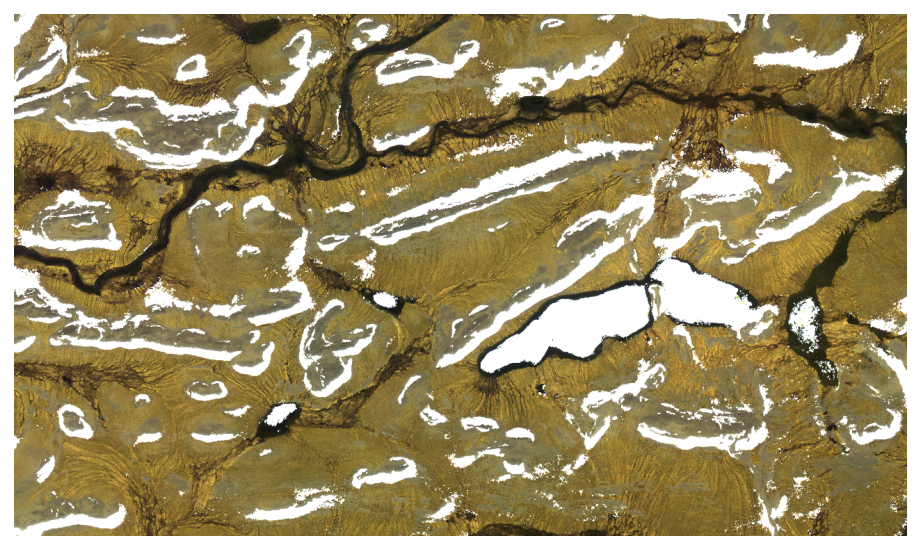

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(rgb,extent=bbox,alpha = 1)
ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Day 1')

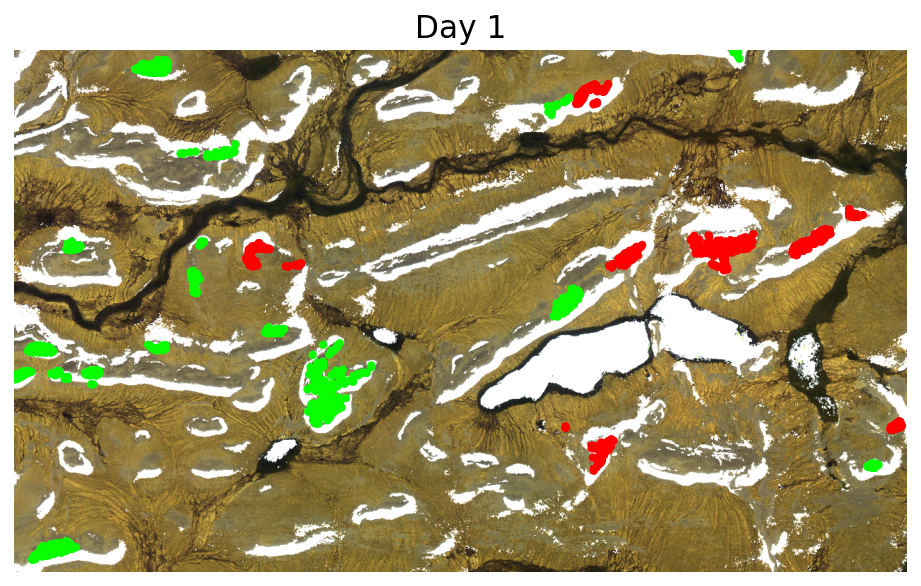

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(rgb,extent=bbox,alpha = 1)
ax.scatter(Day1['x'],Day1['y'],c = Day1['target_vals'],s = 10,cmap ='hsv',vmin = 0,vmax = 3)
ax.axis('off')
ax.set_title('Day 1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Day 20')

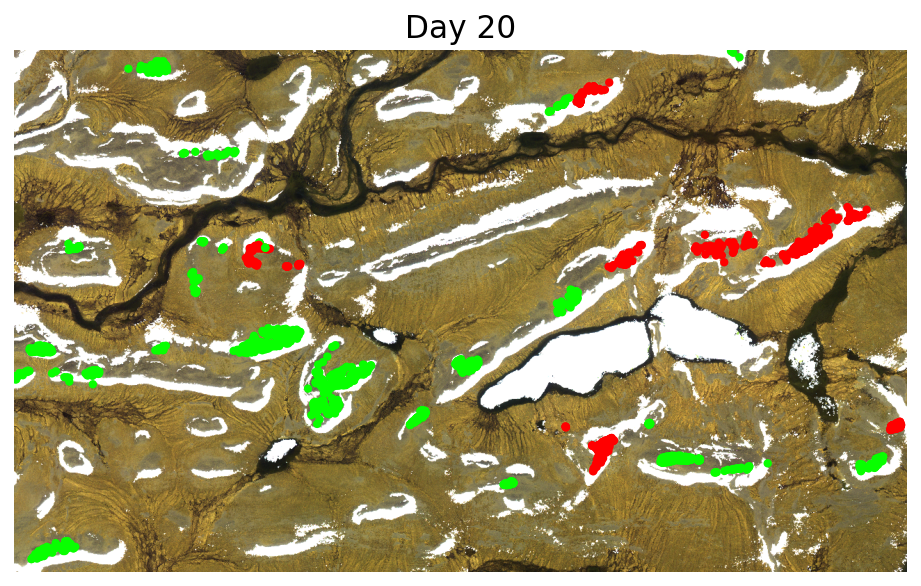

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(rgb,extent=bbox,alpha = 1)
ax.scatter(Day20['x'],Day20['y'],c = Day20['target_vals'],s = 10,cmap ='hsv',vmin = 0,vmax = 3)
ax.axis('off')
ax.set_title('Day 20')

## Land cover mask

Text(0.5, 1.0, 'NDVI: Normalized Difference Vegetation Index')

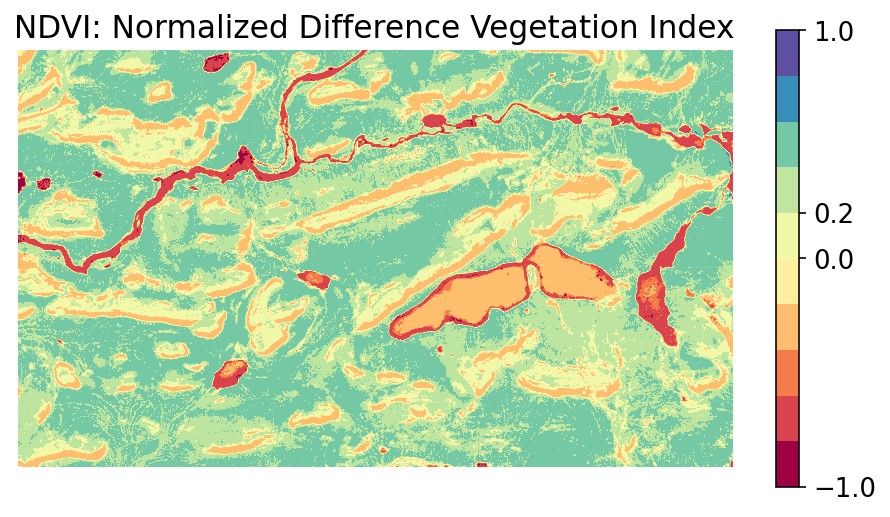

In [10]:
# calculate normalized difference vegetation index (NDVI)
NDVI = (WV_band['band07']-WV_band['band00'])/(WV_band['band07']+WV_band['band00'])

fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap('Spectral', 10)
plt.imshow(NDVI,extent=bbox,cmap = cmap,vmin = -1,vmax = 1)
plt.colorbar(shrink = 0.7,ticks=[-1, 0,0.2,1])
ax.axis('off')
plt.title('NDVI: Normalized Difference Vegetation Index')

(546400.0, 554100.0, 6817000.0, 6821500.0)

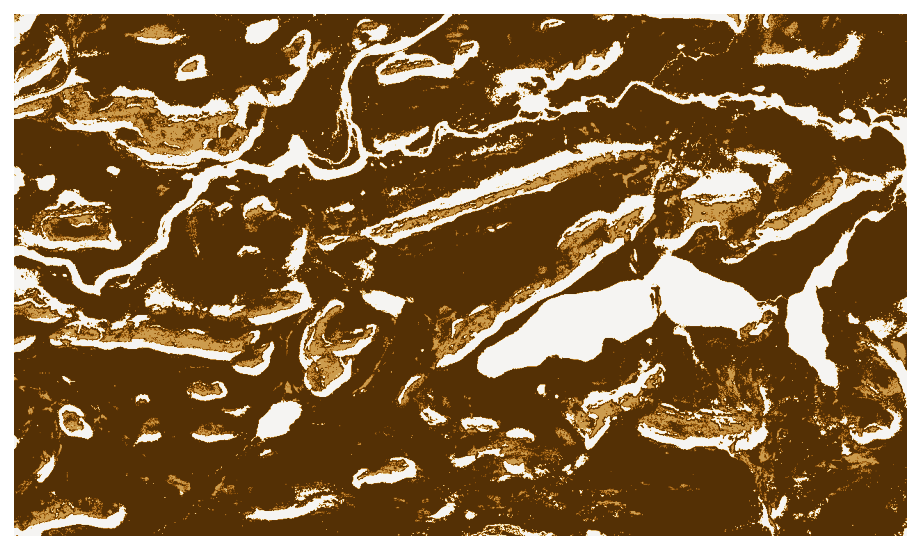

In [11]:
# land cover mask inferred from NDVI
cover_type = np.zeros(NDVI.shape)+1
cover_type[NDVI>0.2] = 2
cover_type[NDVI<0] = 0
mask = np.load('mask.npy')
cover_type[(cover_type==1) & (mask==0)] = 2
fig, ax = plt.subplots(figsize=(8,6))
cmap = plt.get_cmap('BrBG_r', 100)
plt.imshow(cover_type,extent=bbox,cmap = cmap,vmin = -2,vmax = 2)
ax.axis('off')

## Rasterize output data

In [12]:
def rasterize_output(output):
    min_x = bbox[0]
    max_y = bbox[3]
    res = 6
    nx = WV_band['band00'].shape[0]
    ny = WV_band['band00'].shape[1]
    gridded_x = (np.array((output['x']-min_x)/res,dtype = 'int'))
    gridded_y = (np.array((max_y-output['y'])/res,dtype = 'int'))
    gridded = np.zeros((ny,nx))
    gridded[:] = np.nan
    gridded[gridded_x,gridded_y] = np.array(output['target_vals'])
    
    return gridded.T

In [13]:
Day1_raster = rasterize_output(Day1)
Day20_raster = rasterize_output(Day20)

Combine all rasters as one matrix

In [14]:
X_all = np.zeros((WV_band['band00'].shape[0]*WV_band['band00'].shape[1],len(name_list)))
for i,name in enumerate(name_list):
    X_all[:,i] = WV_band[name].reshape(-1)

Extract data with measured rock type

In [15]:
X_Day1 = X_all[~np.isnan(Day1_raster.reshape(-1)),:]
y_Day1 = Day1_raster[~np.isnan(Day1_raster)]
X_Day20 = X_all[~np.isnan(Day20_raster.reshape(-1)),:]
y_Day20 = Day20_raster[~np.isnan(Day20_raster)]

# Classification task with different methods
- Bayes
- Naïve Bayes
- Logistic Regression
- CART
- Bagging

In [16]:
# Define X, y
## You can change it into Day 1 or Day 20
Day = 'Day1'

if Day == 'Day1':
    X = np.copy(X_Day1)
    y = np.copy(y_Day1)
elif Day == 'Day20': 
    X = np.copy(X_Day20)
    y = np.copy(y_Day20)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [18]:
results = {}

## Bayes with one variable
p(c|x) = p(x|c)p(c)/p(x)

In [19]:
# select one variable x: band00
selected_band = 'band00'
selected_index = np.where(selected_band==np.array(name_list))[0][0]

# calculate priors and likelihoods
from scipy import stats
priors = [np.sum(y_train==i)/len(y_train) for i in range(len(np.unique(y_train)))]
likelihoods = [stats.gaussian_kde(X_train[y_train==i,selected_index])
               for i in range(len(np.unique(y_train)))]

Text(0, 0.5, 'density')

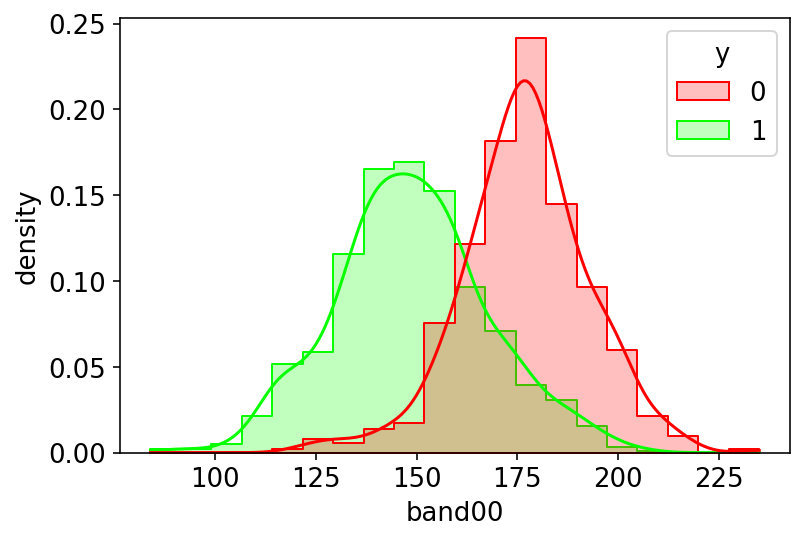

In [20]:
# visualize likelihood p(x|c)
X_train_pd = pd.DataFrame(X_train,columns=name_list)
X_train_pd['y'] = np.array(y_train,dtype = 'int64')
X_train_pd['weight'] = X_train_pd['y']
for i in range(len(np.unique(y_train))):
    X_train_pd['weight'][X_train_pd['y']==i] = 1/np.sum(X_train_pd['y']==i)

sns.histplot(data=X_train_pd, x=selected_band, hue="y",stat="count", weights = 'weight',
             kde=True, palette = 'hsv',element="step", fill=True,bins = 20,hue_norm=(0,3))
plt.ylabel('density')

In [21]:
# calculate the posterior p(c|x)
def posterior_Bayes(x,likelihoods,priors):
    pos= [likelihoods[i](x)*priors[i] for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

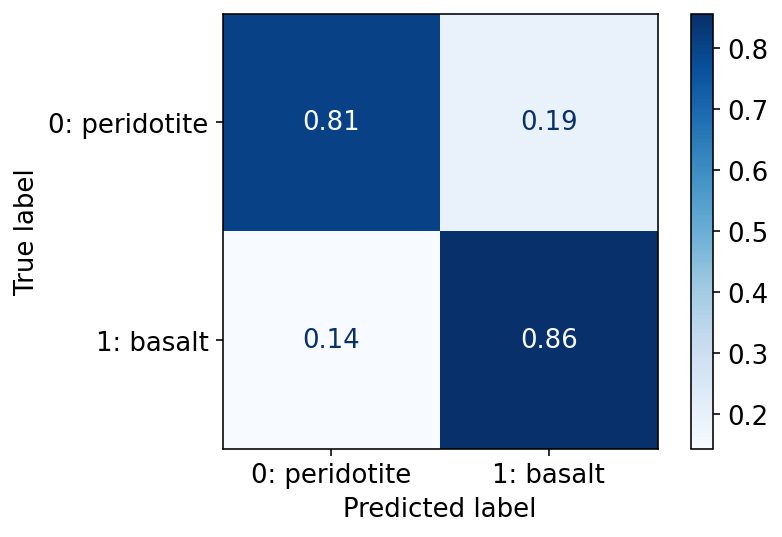

In [22]:
# confusion matrix on test data
results['Bayes: x'] = posterior_Bayes(X_test[:,selected_index],likelihoods,priors)
y_pred = np.argmax(results['Bayes: x'],axis = 1)
if len(priors)==3:
    class_label= ['0: peridotite','1: basalt','2: gabbro']
elif len(priors)==2:
    class_label= ['0: peridotite','1: basalt']
cm = confusion_matrix(np.array(y_test,dtype ='int64'), y_pred, labels=np.unique(y_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.show()

In [23]:
y_pred = np.argmax(posterior_Bayes(X_all[:,selected_index],likelihoods,priors),axis = 1)
y_pred = np.array(y_pred.reshape(WV_band['band00'].shape),dtype = 'float64')

(-0.5, 1283.5, 750.5, -0.5)

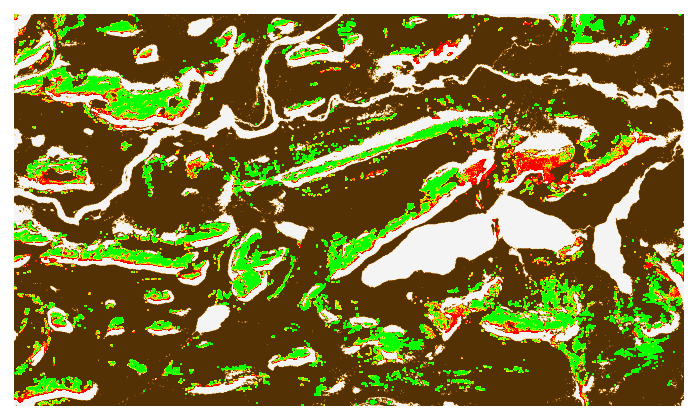

In [24]:
cover_type_vis = np.copy(cover_type)
cover_type_vis[cover_type_vis==1] = np.nan
plt.imshow(y_pred,cmap ='hsv',vmin = 0,vmax = 3)
plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
plt.axis('off')

## Naïve Bayes with two variables
p(c|x1,x2) = p(x1|c)p(x2|c)p(c)/p(x1,x2) 

<AxesSubplot:xlabel='band00', ylabel='band07'>

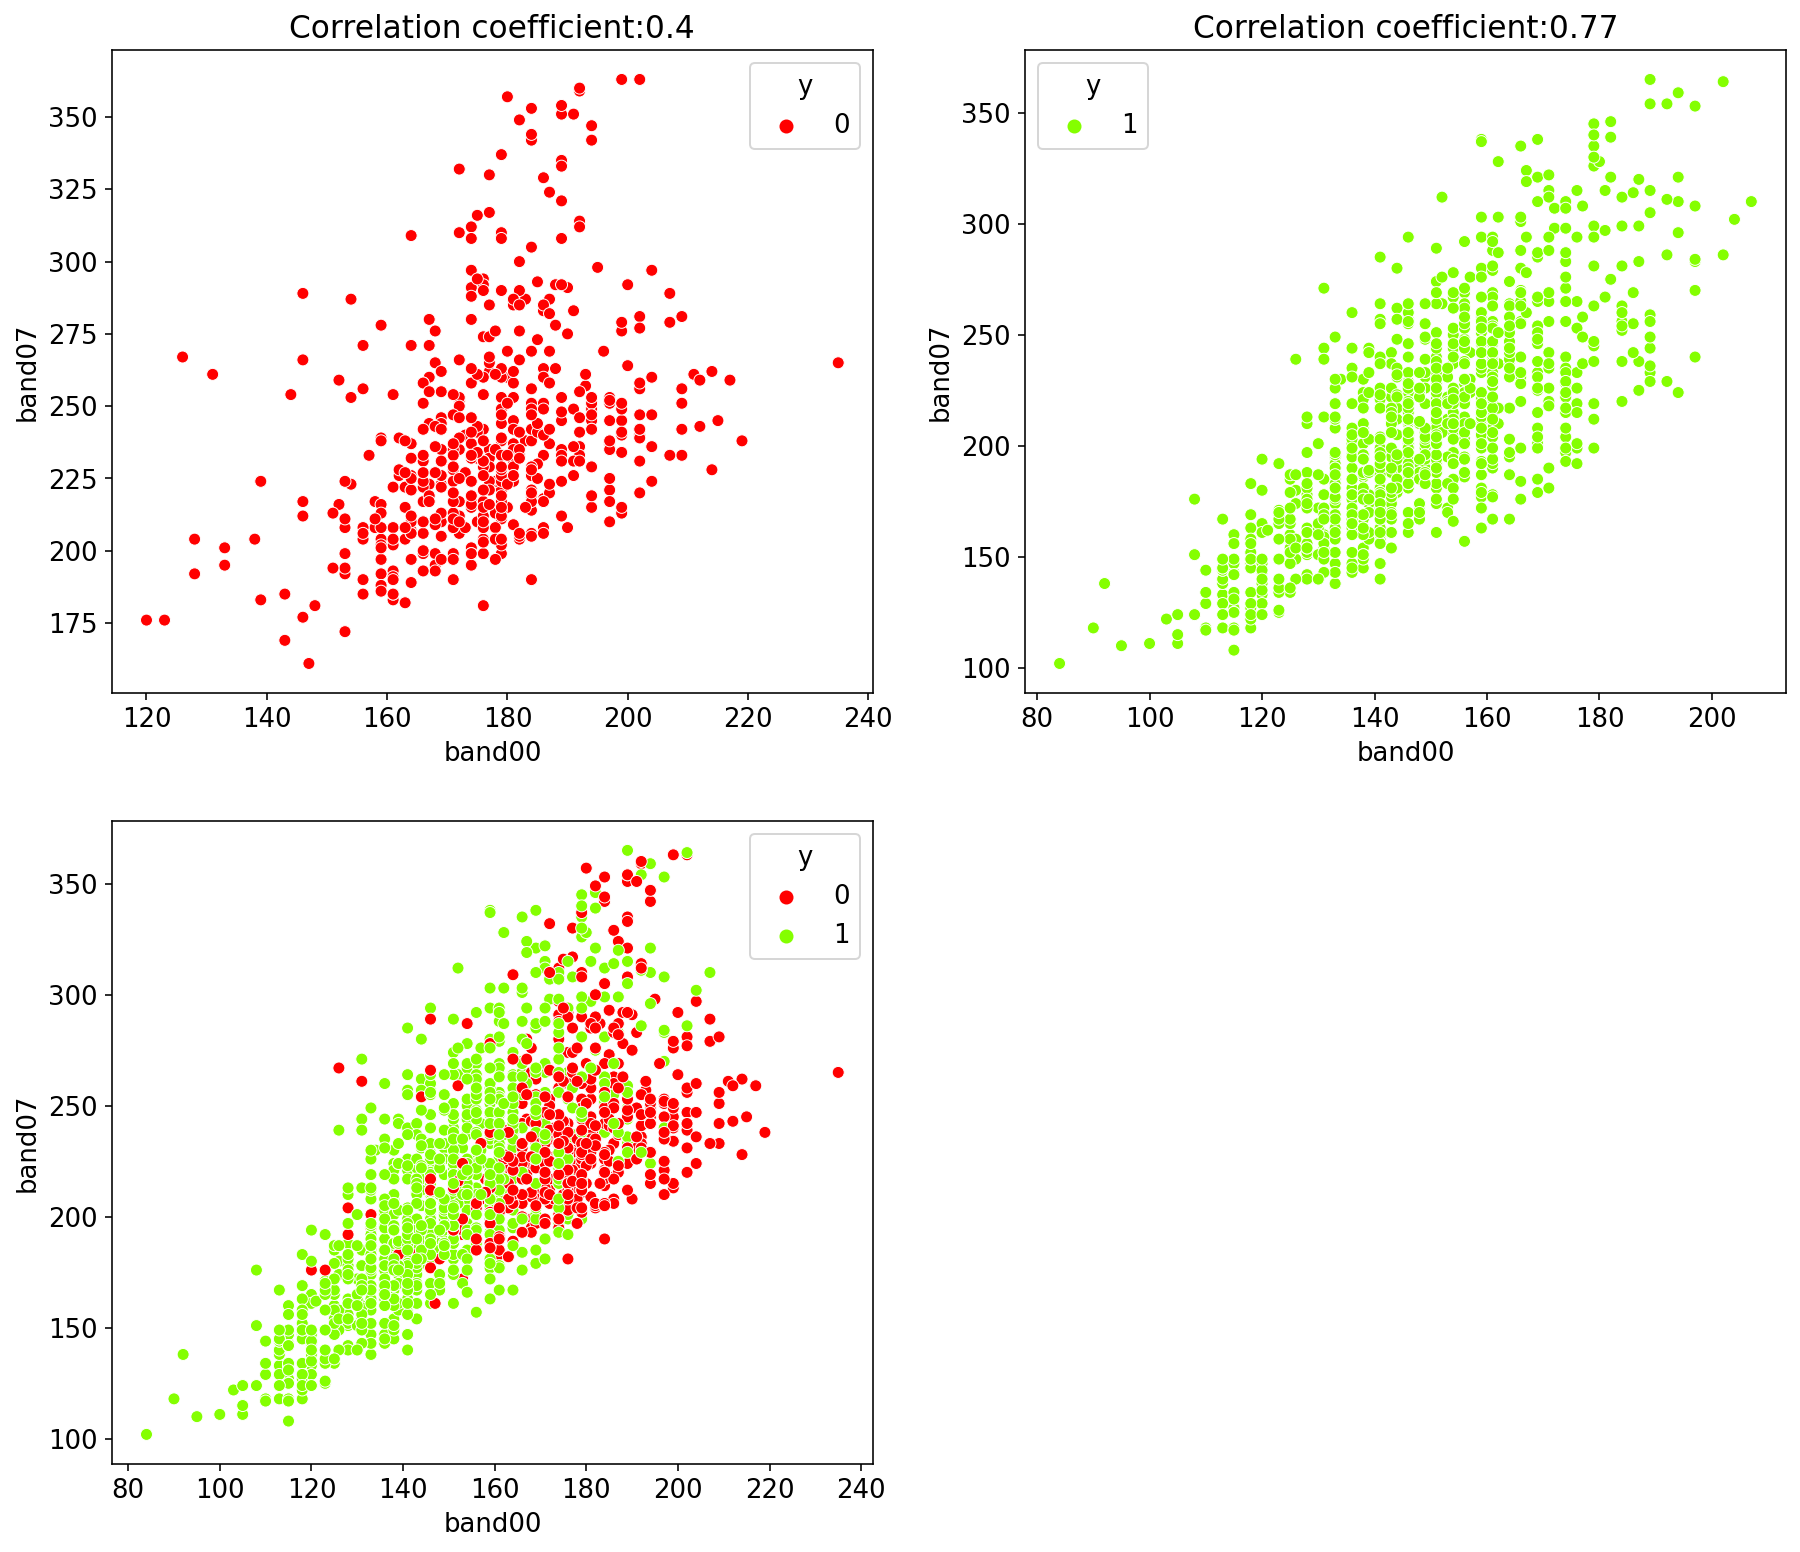

In [25]:
selected_band_list = ['band00','band07']
plt.figure(figsize=(15,13))
for i in range(len(priors)): 
    ax = plt.subplot(2, 2, i+1)
    sns.scatterplot(data=X_train_pd[X_train_pd['y']==i], 
                    x=selected_band_list[0], 
                    y=selected_band_list[1],hue = 'y',palette = 'hsv',hue_norm=(0,4))
    corr = np.corrcoef(X_train_pd[X_train_pd['y']==i][selected_band_list[0]],
                       X_train_pd[X_train_pd['y']==i][selected_band_list[1]])[0,1]
    ax.set_title('Correlation coefficient:'+str(np.round(corr,2)))

ax = plt.subplot(2, 2, len(priors)+1)
sns.scatterplot(data=X_train_pd, x=selected_band_list[0], y=selected_band_list[1],hue = 'y',palette = 'hsv',hue_norm=(0,4))

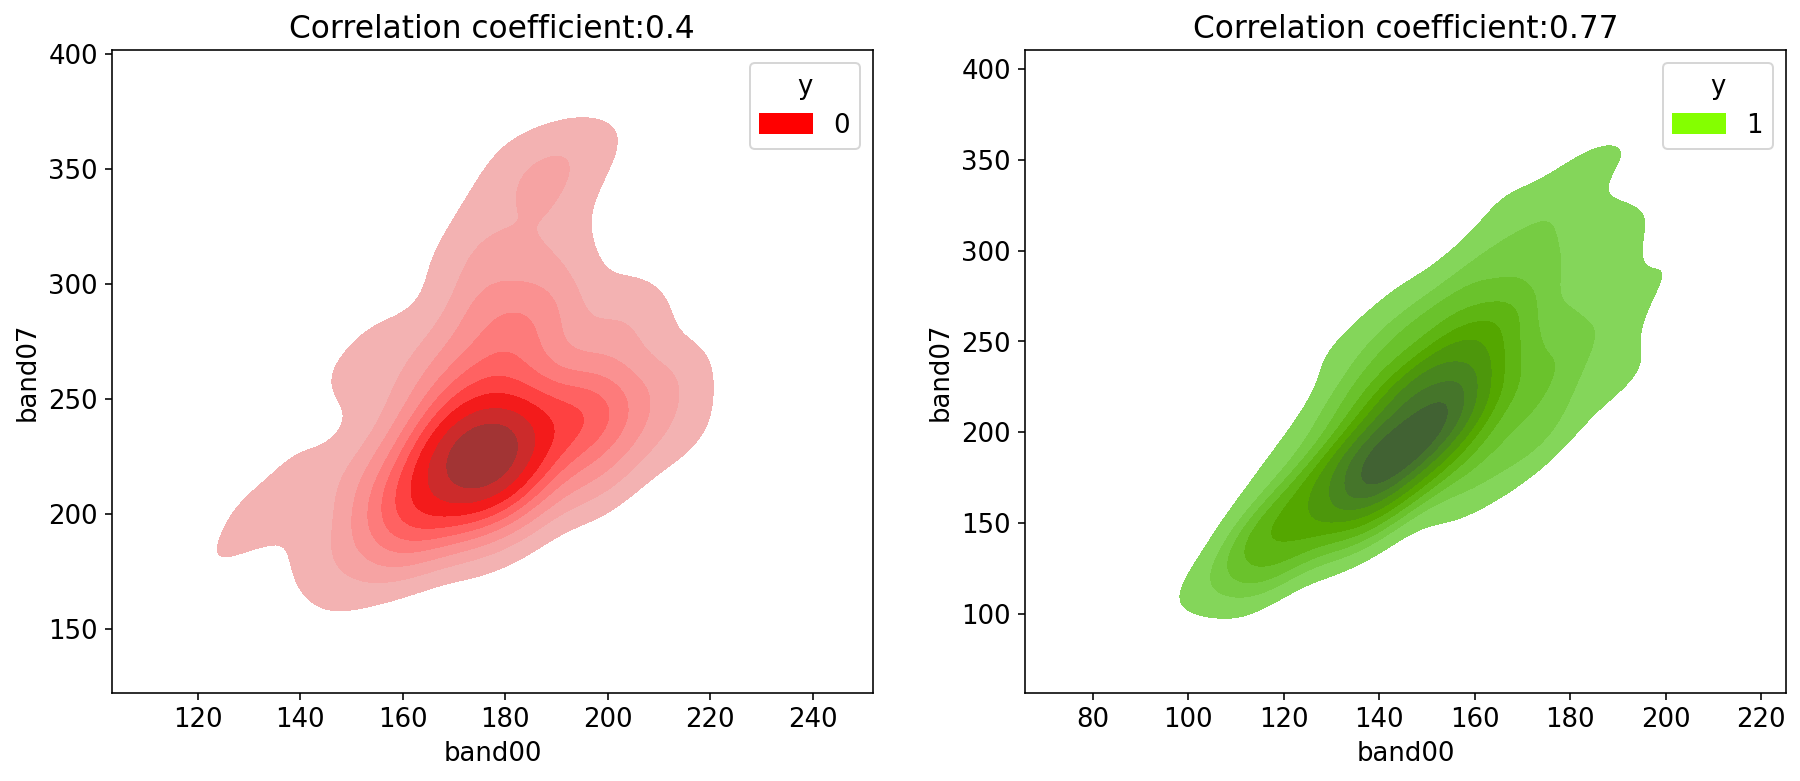

In [26]:
selected_band_list = ['band00','band07']
plt.figure(figsize=(15,13))
for i in range(len(priors)): 
    ax = plt.subplot(2, 2, i+1)
    sns.kdeplot(data=X_train_pd[X_train_pd['y']==i], 
                    x=selected_band_list[0], 
                    y=selected_band_list[1],hue = 'y',palette = 'hsv',hue_norm=(0,4),fill=True)
    corr = np.corrcoef(X_train_pd[X_train_pd['y']==i][selected_band_list[0]],
                       X_train_pd[X_train_pd['y']==i][selected_band_list[1]])[0,1]
    ax.set_title('Correlation coefficient:'+str(np.round(corr,2)))

In [27]:
# calculate likelihoods
likelihoods_list = {}
for selected_band in selected_band_list:
    selected_index = np.where(selected_band==np.array(name_list))[0][0]
    likelihoods = [stats.gaussian_kde(X_train[y_train==i,selected_index])
                   for i in range(len(np.unique(y_train)))]
    likelihoods_list[selected_band] = likelihoods

In [28]:
# calculate the posterior p(c|x1,x2) = p(x1|c)p(x2|c)p(c)/p(x1,x2) 
def posterior_Naive(x,priors,likelihoods_list):
    selected_band = selected_band_list[0]
    likelihoods = likelihoods_list[selected_band]
    selected_index = np.where(selected_band==np.array(name_list))[0][0]
    
    pos= [likelihoods[i](x[:,selected_index])*priors[i] for i in range(len(likelihoods))]
    for selected_band in selected_band_list[1:]:
        selected_index = np.where(selected_band==np.array(name_list))[0][0]
        likelihoods = likelihoods_list[selected_band]
        pos = [pos[i]*likelihoods[i](x[:,selected_index]) for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

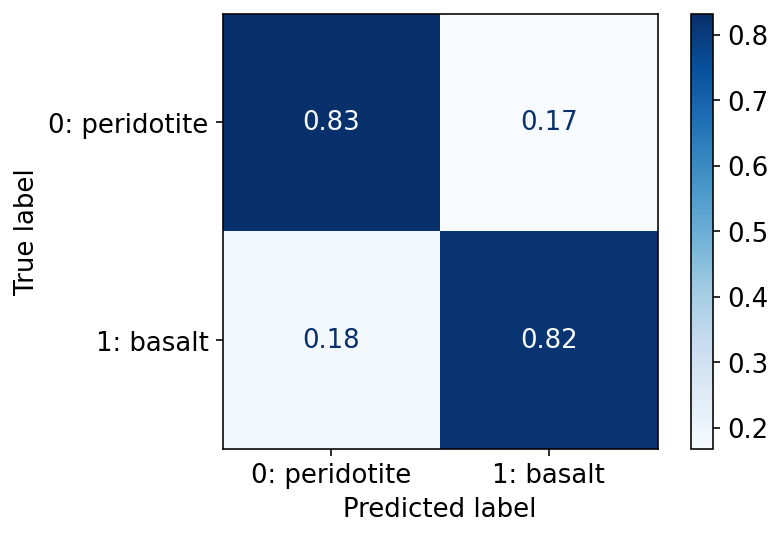

In [29]:
# confusion matrix on test data
results['Naïve Bayes: x1,x2'] = posterior_Naive(X_test,priors,likelihoods_list)
y_pred = np.argmax(results['Naïve Bayes: x1,x2'],axis = 1)

if len(priors)==3:
    class_label= ['0: peridotite','1: basalt','2: gabbro']
elif len(priors)==2:
    class_label= ['0: peridotite','1: basalt']
cm = confusion_matrix(np.array(y_test,dtype ='int64'), y_pred, labels=np.unique(y_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.show()

In [30]:
y_pred = np.argmax(posterior_Naive(X_all,priors,likelihoods_list),axis = 1)
y_pred = np.array(y_pred.reshape(WV_band['band00'].shape),dtype = 'float64')

(-0.5, 1283.5, 750.5, -0.5)

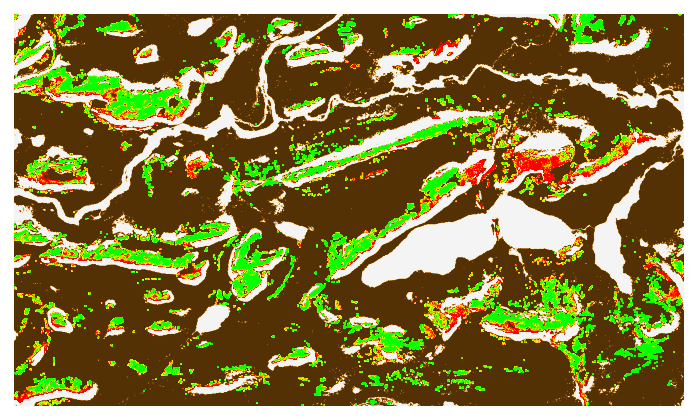

In [31]:
plt.imshow(y_pred,cmap ='hsv',vmin = 0,vmax = 3)
plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
plt.axis('off')

## Full Bayes with two variables
p(c|x1,x2) = p(x1,x2|c)p(c)/p(x1,x2) 

In [32]:
# calculate likelihoods
selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
likelihoods = [stats.gaussian_kde(X_train[y_train==i,:][:,selected_index].T)
               for i in range(len(np.unique(y_train)))]

In [33]:
# calculate the posterior p(c|x1,x2) = p(x1,x2|c)p(c)/p(x1,x2) 
def posterior_full_Bayes(x,likelihoods,priors):
    selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
    pos= [likelihoods[i](x[:,selected_index].T)*priors[i] for i in range(len(likelihoods))]
    pos=pos/np.sum(pos,axis =0)
    return pos.T

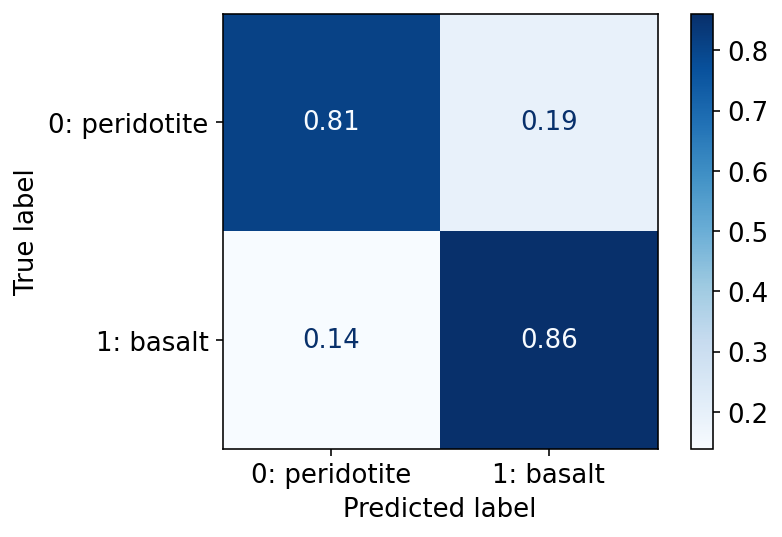

In [34]:
# confusion matrix on test data
results['Full Bayes: x1,x2'] = posterior_full_Bayes(X_test,likelihoods,priors)
y_pred = np.argmax(results['Full Bayes: x1,x2'],axis = 1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
if len(priors)==3:
    class_label= ['0: peridotite','1: basalt','2: gabbro']
elif len(priors)==2:
    class_label= ['0: peridotite','1: basalt']
cm = confusion_matrix(np.array(y_test,dtype ='int64'), y_pred, labels=np.unique(y_pred), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot(cmap = 'Blues')
plt.show()

## Precision recall analysis

In [35]:
def precision_recall(y_pred_prob,threshold,y_test = y_test):
    prediction = (y_pred_prob[:,0]>threshold)
    TP = np.sum(prediction[y_test==0]) # 
    PP = np.sum(prediction) # predicted positive
    P = np.sum(y_test==0)# positive
    precision = TP/PP
    if np.isnan(precision):
        precision = 1
    recall = TP/P
    return [precision,recall]

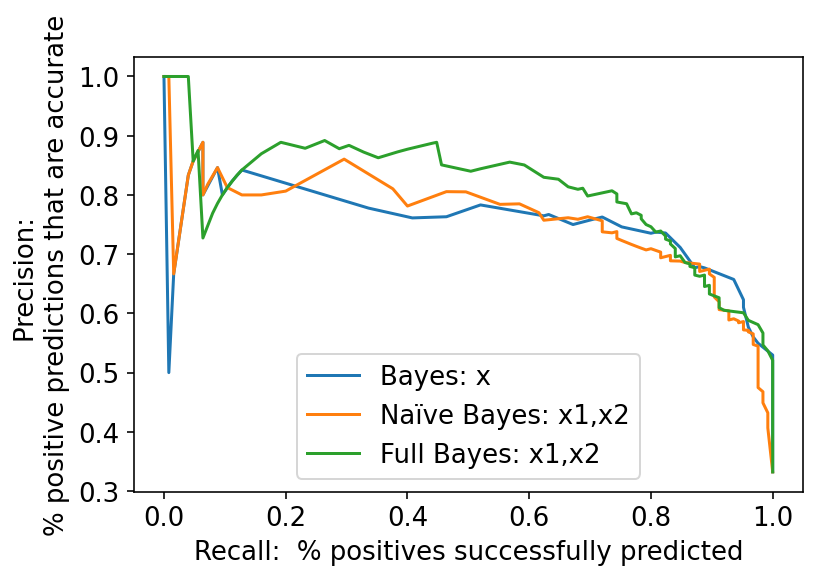

In [36]:
for method in results.keys():
    PR = np.array([precision_recall(results[method],threshold) for threshold in np.linspace(0,1,100)])
    plt.plot(PR[:,1],PR[:,0],'-', label = method)
plt.xlabel('Recall:  % positives successfully predicted')
plt.ylabel('Precision: \n% positive predictions that are accurate')
plt.legend()

## Full Bayes: Day 1 and Day 20

In [37]:
pred_map = {}
pred_entropy = {}
y_test_list = {}

In [38]:
# Full Bayes: Day 1 and Day 20
for Day in ['Day1','Day20']:
    if Day == 'Day1':
        X = np.copy(X_Day1)
        y = np.copy(y_Day1)
    elif Day == 'Day20': 
        X = np.copy(X_Day20)
        y = np.copy(y_Day20)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # calculate priors
    priors = [np.sum(y_train==i)/len(y_train) for i in range(len(np.unique(y_train)))]
    
    # calculate likelihoods
    selected_index = [np.where(selected_band==np.array(name_list))[0][0] for selected_band in selected_band_list]
    likelihoods = [stats.gaussian_kde(X_train[y_train==i,:][:,selected_index].T)
                   for i in range(len(np.unique(y_train)))]
    
    # inference: test dataset
    y_test_list[Day] = y_test
    results['Full Bayes '+Day+': x1,x2'] = posterior_full_Bayes(X_test,likelihoods,priors)
    
    # inference: full map
    y_pred_prob = posterior_full_Bayes(X_all,likelihoods,priors)
    y_pred = np.argmax(y_pred_prob,axis = 1)
    y_pred = np.array(y_pred.reshape(WV_band['band00'].shape),dtype = 'float64')
    pred_map[Day] = y_pred
    # inference: entropy
    entropy = -y_pred_prob[:,0]*np.log10(y_pred_prob[:,0])
    entropy = entropy.reshape(WV_band['band00'].shape)
    pred_entropy[Day] = entropy

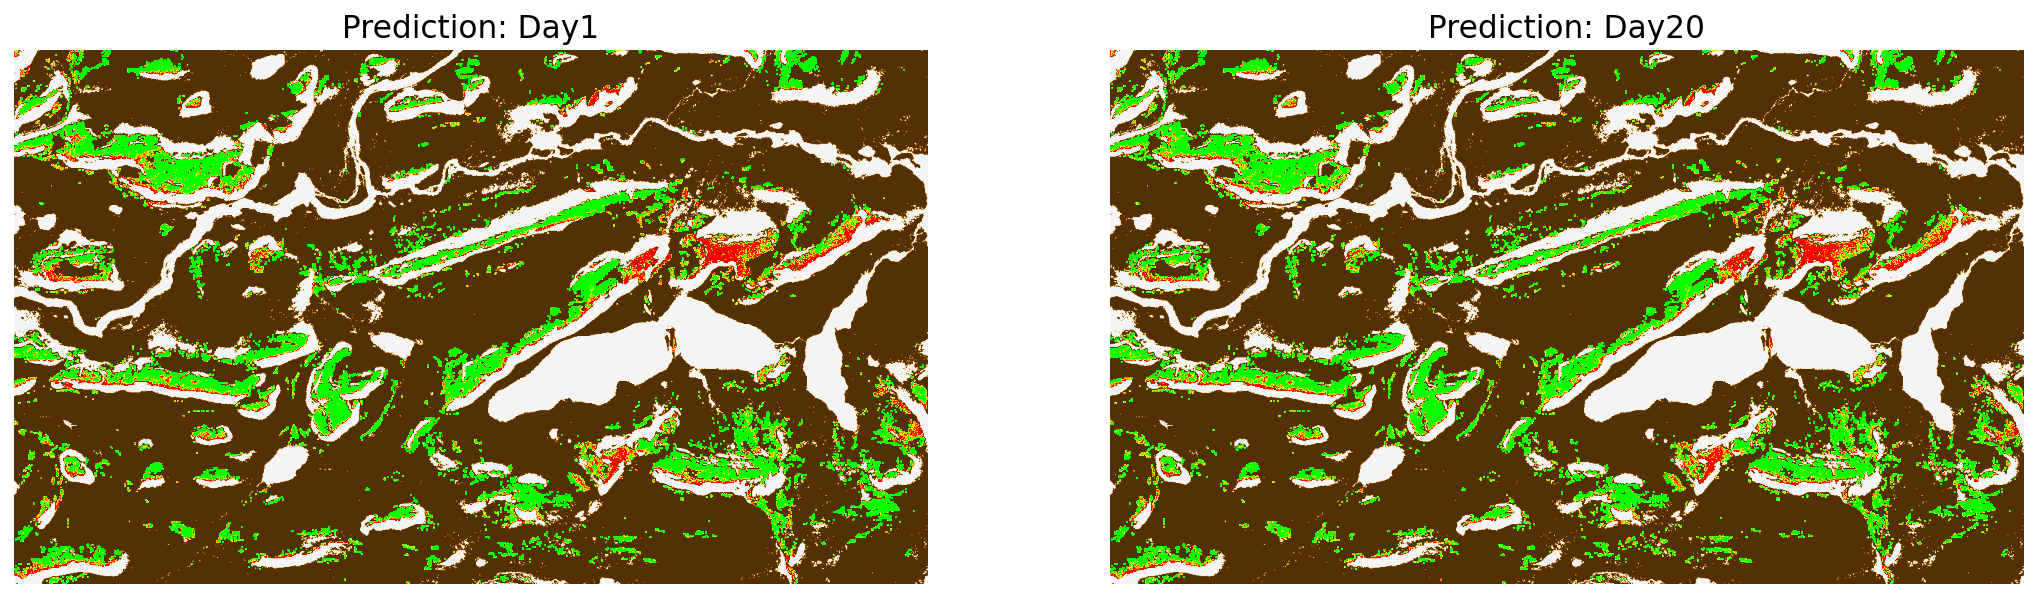

In [39]:
plt.figure(figsize=(18,6))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_map[Day],cmap ='hsv',vmin = 0,vmax = 3)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Prediction: '+Day)
    i = i+1

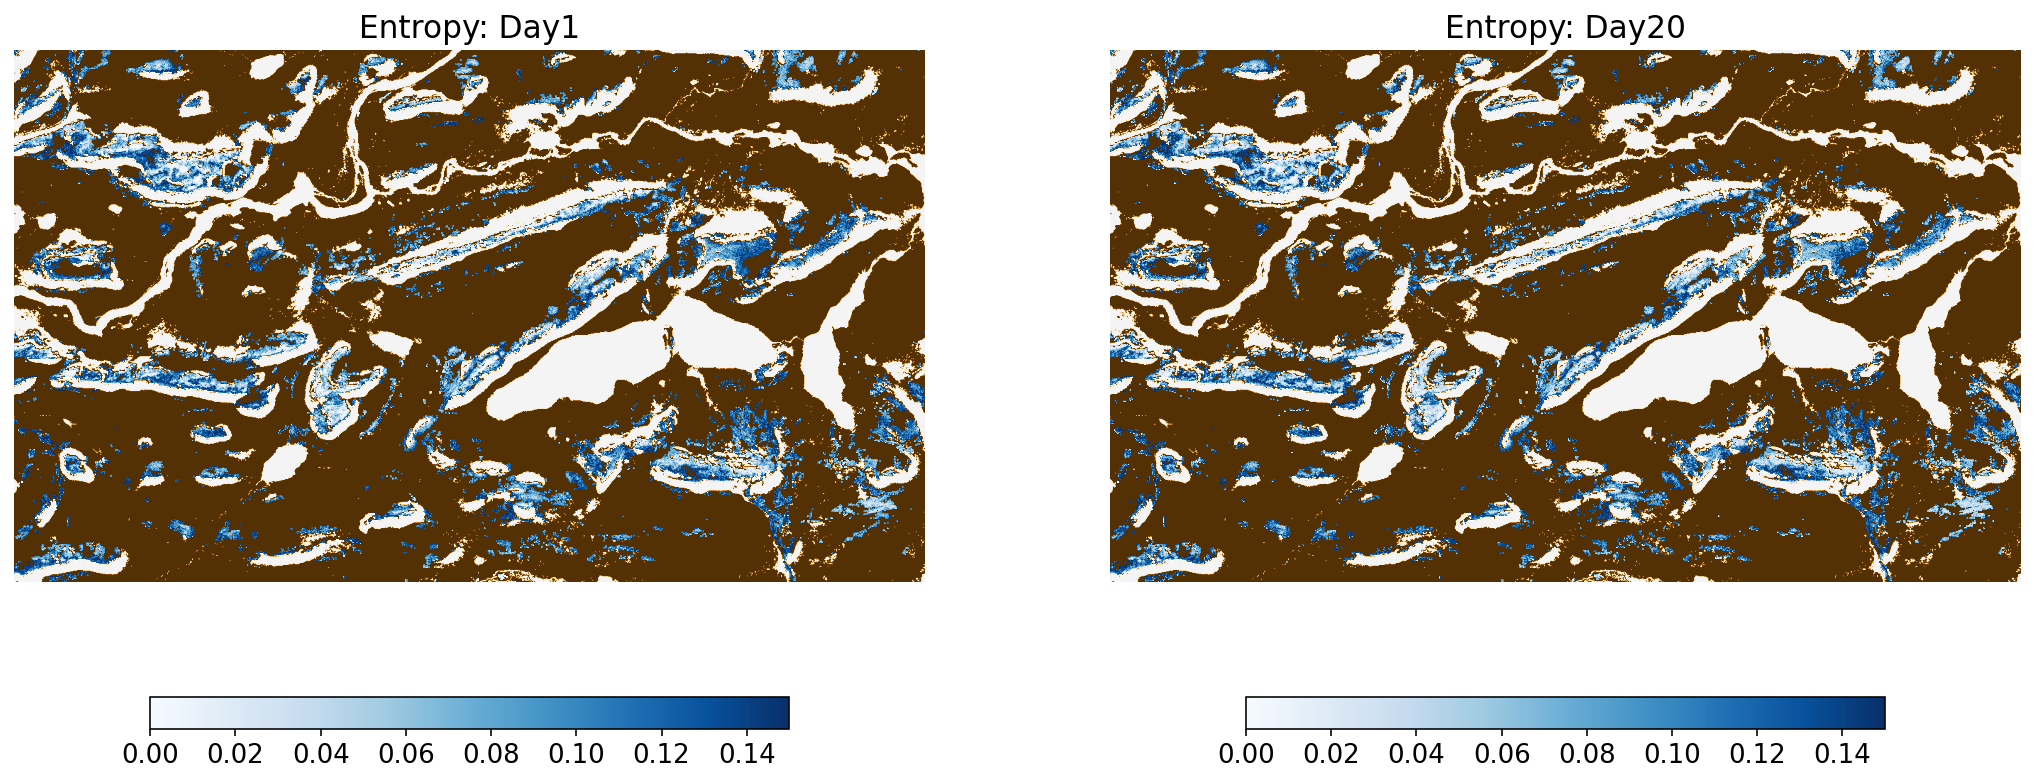

In [40]:
plt.figure(figsize=(18,7))
i = 1
for Day in ['Day1','Day20']:
    ax = plt.subplot(1, 2, i)
    plt.imshow(pred_entropy[Day],cmap = 'Blues',vmin = 0,vmax = 0.15)
    plt.colorbar(orientation = 'horizontal',shrink = 0.7)
    plt.imshow(cover_type_vis,cmap = 'BrBG_r',alpha = 1,vmin = -2,vmax = 2)
    plt.axis('off')
    plt.title('Entropy: '+Day)
    i = i+1

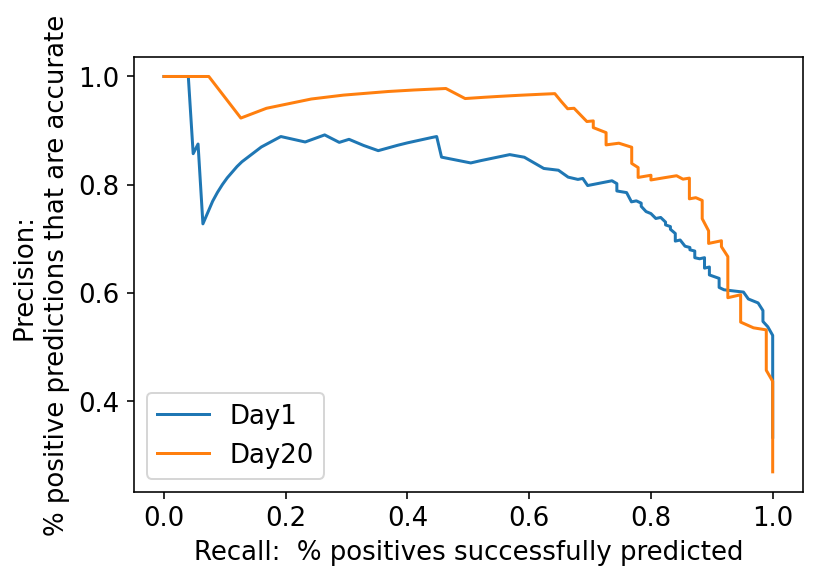

In [41]:
for Day in ['Day1','Day20']:
    PR = np.array([precision_recall(results['Full Bayes '+Day+': x1,x2'], threshold,
                                    y_test_list[Day]) for threshold in np.linspace(0,1,100)])
    plt.plot(PR[:,1],PR[:,0],'-', label = Day)
plt.xlabel('Recall:  % positives successfully predicted')
plt.ylabel('Precision: \n% positive predictions that are accurate')
plt.legend()